Moving average
* smoothing out short-term flactuations
* remove outliers 
* highlighting long-term trends or cycles
df.rolling(window=n).mean()

plotting aggregate values
a = df.group_by(x).mean()
a.plot()


upper bound ma + 2*rolling std
lower bound ma - 2*rolling std


Autocorrelation is measured as the correlation between a time series and a delayed copy of itself. It is used to find repetitive patterns of periodic signal in time series. The plot_acf function computes margins of uncertainity. Values above the shaded region(confidence intervals) have statistical significane with the lagged version of itself.

seasonality 
Library import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df) 
decomposition.seasonal
decomposition.trend
decomposition.residual(noise)


DVC Data Tags  
* 'v0-raw' - Raw Data (Files sample_submission.csv, store.csv, train.csv, test.csv)
* 'v1-cleaned' - Cleaned Data (Files store_cleaned.csv & train_cleaned.csv) 
* 'v1-merged' - Store and Sales merged data
* 'v1.1-cleaned' - Thoroughly cleaned data (Files - store_cleaned_latest.csv & train_cleaned_latest.csv)  
* 'v1.1-merged' - Latest merged data using latest cleaned files. (Files - train_merged_latest.csv)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append(os.path.abspath(os.path.join('data')))
sys.path.insert(0,'../scripts/')
import warnings
warnings.filterwarnings('ignore')

from utils import Utils
from datacleaner import DataCleaner


In [3]:
utils = Utils()
cleaner = DataCleaner()

Load dataset

Dataset field descriptions
* Id - an Id that represents a (Store, Date) duple within the test set  

* Store - a unique Id for each store  

* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended. Read more about assortment here
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [30]:
store_df = utils.load_data_dvc('v0-raw','data/store.csv','/home/teddy/dev/learning/10 academy/working/pharma_sales_prediction')
sales_train_df = utils.load_data_dvc('v0-raw','data/train.csv','/home/teddy/dev/learning/10 academy/working/pharma_sales_prediction')
sales_test_df = utils.load_data_dvc('v0-raw','data/test.csv','/home/teddy/dev/learning/10 academy/working/pharma_sales_prediction')

In [5]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Check column datatypes and missing values

In [7]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [8]:
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [9]:
sales_train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [10]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [11]:
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [12]:
store_df['Promo2SinceYear'].unique()

array([  nan, 2010., 2011., 2012., 2009., 2014., 2015., 2013.])

In [13]:
store_df['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [14]:
store_df[store_df['Promo2'] == 0][['Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval']]

,Promo2SinceYear,Promo2SinceWeek,PromoInterval
0,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
...,...,...,...
1107,NaN,NaN,NaN
1109,NaN,NaN,NaN
1111,NaN,NaN,NaN
1112,NaN,NaN,NaN


We can see from the above table for stores not participating in consecutive promotion we have NaN values for Promo2SinceYear, Promo2SinceWeek and PromoInterval. Since these stores didn't participate in the promo it makes sense to replace Promo2SinceYear and Promo2SinceMonth with 0.0 since both columns have a datatype of float. We can replace 'null' for the PromoInterval column since its datatype is an object.

In [15]:
store_df['Promo2SinceYear'].fillna(0, inplace=True)
store_df['Promo2SinceWeek'].fillna(0, inplace=True)

In [16]:
store_df['PromoInterval'].fillna('null', inplace=True)

In [17]:
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

From the above data we can see that even though there are stores where there is a competiting store nearby, there are about 351 stores where we don't know when the competing store was opened. Possible interpretation of this would be the competing stores may have existed before the store in reference was opened. In that case it would not make sense to replace(fill) these columns with either mean or median. Filling with zero makes better sense.

In [19]:
store_df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
store_df['CompetitionOpenSinceYear'].fillna(0, inplace=True)


In [21]:
store_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          3
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

The only column with missing values is CompetitionDistance

In [20]:
store_df[store_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,0.0,0.0,0,0.0,0.0,null
621,622,a,c,NaN,0.0,0.0,0,0.0,0.0,null
878,879,d,a,NaN,0.0,0.0,1,5.0,2013.0,"Feb,May,Aug,Nov"


<AxesSubplot:>

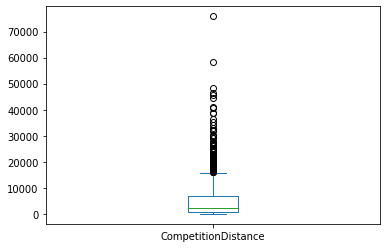

In [24]:
store_df['CompetitionDistance'].plot.box()

A better way to fill the missing values in CompetitionDistance column would be to use the median of the column. The choice is based on the fact that it is a numeric column and also there is a presence of outliers within the columns so imputing using median seems to be a better choice

In [25]:
filled_store_df = cleaner.fill_missing_values_numeric(store_df, 'median')

In [26]:
filled_store_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

We don't have any missing values remaining in our data

In [27]:
filled_store_df['CompetitionOpenSinceMonth'].unique()

array([ 9., 11., 12.,  4., 10.,  8.,  0.,  3.,  6.,  5.,  1.,  2.,  7.])

Check all categorical columns if the contain the right values

In [28]:
sales_train_df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

Contains and integer value of 0. This should be converted to str.

In [31]:
sales_test_df['StateHoliday'].unique()

array(['0', 'a'], dtype=object)

In [32]:
# Convert values to string for train data
sales_train_df = cleaner.convert_to_string(sales_train_df, cols=['StateHoliday'])

Merge dataset and export

In [45]:
sales_train_df['Date'] = pd.to_datetime(sales_train_df['Date'])

In [219]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [245]:
merged_train_df = pd.merge(sales_train_df, filled_store_df, on='Store')

In [246]:
merged_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null


In [247]:
utils.save_csv(filled_store_df, '../data/store_cleaned_latest.csv')
utils.save_csv(sales_train_df, '../data/train_cleaned_latest.csv')

File Successfully Saved.!!!
File Successfully Saved.!!!


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [248]:
utils.save_csv(merged_train_df, '../data/train_merged_latest.csv')

File Successfully Saved.!!!


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


Univariate Analysis

In [249]:
merged_train_df.set_index('Date', inplace=True)

In [250]:
merged_train_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null
2015-07-30,1,4,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null
2015-07-29,1,3,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null
2015-07-28,1,2,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null
2015-07-27,1,1,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,null


In [251]:
merged_train_df.index.min()

Timestamp('2013-01-01 00:00:00')

In [252]:
merged_train_df.index.max()

Timestamp('2015-07-31 00:00:00')

The range of our dataset is from 2013-01-01 to 2015-07-31

#### What can you say about the correlation between sales and number of customers?

Average Sales per Month

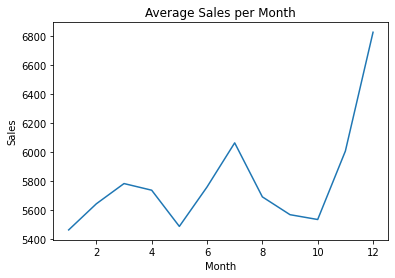

In [253]:
index_by_month = merged_train_df.index.month
ax = merged_train_df.groupby(index_by_month)['Sales'].mean().plot()
ax.set_title("Average Sales per Month")
ax.set_xlabel("Month")
ax.set_ylabel("Sales")
plt.show()

From the above plot we can see a very steep increase in sales towards the end of the year. January, May and October is when we have the lowest average sales.

Average Customers per Month

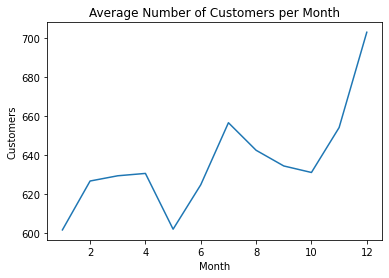

In [254]:
index_by_month = merged_train_df.index.month
ax = merged_train_df.groupby(index_by_month)['Customers'].mean().plot()
ax.set_title("Average Number of Customers per Month")
ax.set_xlabel("Month")
ax.set_ylabel("Customers")
plt.show()

The graph of the average number of customers per month follows very closely with the graph of the average sales per month. This shows there is some correlation between average sales and average customers.

In [255]:
correlations = merged_train_df.corr()['Sales'].sort_values(ascending=False)
correlations

Sales                        1.000000
Customers                    0.894711
Open                         0.678472
Promo                        0.452345
SchoolHoliday                0.085124
Store                        0.005126
CompetitionOpenSinceYear     0.002749
CompetitionOpenSinceMonth   -0.012431
CompetitionDistance         -0.018869
Promo2SinceWeek             -0.044143
Promo2                      -0.091040
Promo2SinceYear             -0.091056
DayOfWeek                   -0.462125
Name: Sales, dtype: float64

The insight we got from comparing the average sales per month and the average customers per month has been verified from the correlations. The two graphs following each other very closely indicated that the two features were highly correlated and that has been verified. As number of customers increase the average sales also increases

#### 1. Check for distribution in both training and test sets - are the promotions distributed similarly between these two groups?

In [256]:
test_promo_dist = sales_test_df['Promo']
train_promo_dist = sales_train_df['Promo']

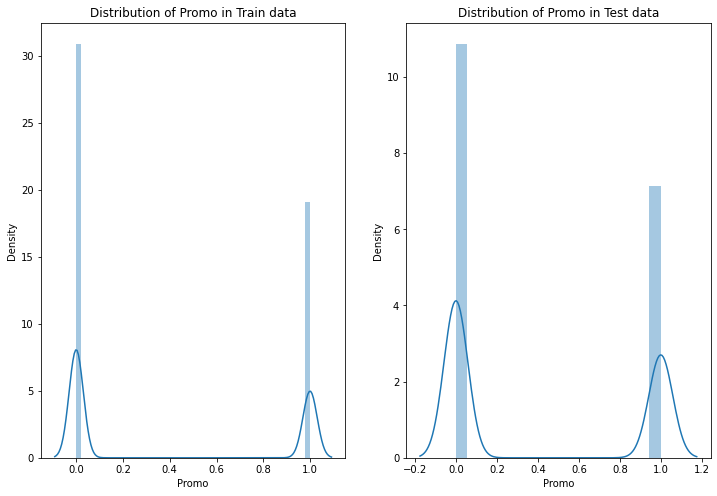

In [257]:
fig, axes = plt.subplots(1,2,figsize=(12,8))
sns.distplot(train_promo_dist, ax=axes[0])
axes[0].set_title('Distribution of Promo in Train data')
sns.distplot(test_promo_dist, ax=axes[1])
axes[1].set_title('Distribution of Promo in Test data')
plt.show()

#### 2. Check & compare sales behavior before, during and after holidays

Columns concerned with holidays are StateHoliday and SchoolHoliday.  
Possible Values for StateHoliday are  a - Public Holiday, b - Easter Holiday, c - Christmas, 0 - None  
Possible Values for SchoolHoliday 1 - Store,Date was affected by closure of public schools 

Analysis For Public Holidays

In [259]:
merged_train_df.index

DatetimeIndex(['2015-07-31', '2015-07-30', '2015-07-29', '2015-07-28',
               '2015-07-27', '2015-07-26', '2015-07-25', '2015-07-24',
               '2015-07-23', '2015-07-22',
               ...
               '2013-01-10', '2013-01-09', '2013-01-08', '2013-01-07',
               '2013-01-06', '2013-01-05', '2013-01-04', '2013-01-03',
               '2013-01-02', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [261]:
public_holiday_dates = merged_train_df.query('StateHoliday == "a"').index.unique()

In [262]:
dates = pd.DatetimeIndex(public_holiday_dates)

In [263]:
day_month = []
for date in dates:
    if (date.day,date.month,date.year) not in day_month:
        day_month.append((date.day,date.month,date.year))
        

In [264]:
len(day_month)

27

There are 27 public holidays within the dataset. We're going to be analyzing the sales behaviour before the holiday, during the holiday and after the holiday. For this analysis we're going to use the following range.  
Analysis of sales behaviour before the holiday - [Start <-> holiday-1)  
Analysis of sales behaviour during the holiday - [holiday - 1 <-> holiday + 1]  
Analysis of sales behaviour after the holiday - (holiday + 1 <-> end]  


In [265]:
# def analyze_sales_holiday(dates, df):
#     sales_by_holiday = {}
#     before = None
#     during = None
#     after = None
#     for date in dates:
#         year = date.year
#         month = date.month
#         day = date.day
#         before = df.query(f'day < {day} and month < {month} and year == {year}')
#         during = df.query(f'day == {day} and month == {month} and year == {year}')
#         after = df.query(f'day > {day} and month > {month} and year == {year}')
#         sales_by_holiday[date] = {'before': before, 'during': during, 'after': after}
#     return sales_by_holiday
        

In [266]:
merged_train_df['day'] = merged_train_df.index.day
merged_train_df['month'] = merged_train_df.index.month
merged_train_df['year'] = merged_train_df.index.year


In [267]:
# sales_by_holiday = analyze_sales_holiday(dates, merged_train_df)

In [268]:
# for date in list(sales_by_holiday.keys()):
#     fig, axes = plt.subplots(1,3,figsize=(12,8))
#     holiday = sales_by_holiday[date]

#     mon = holiday['before'].index.month
#     before = holiday['before'].groupby(mon)['Sales'].mean()
#     sns.lineplot(x=before.index, y=before, ax=axes[0])
#     axes[0].set_title('Before the holiday sales')
    
#     # day = holiday['during'].index.day
#     # during = holiday['during'].groupby(day)['Sales'].mean()
#     during = holiday['during']['Sales']
#     day = during.index.day
#     sns.lineplot(x=during.groupby(day).mean().index, y=during.groupby(day).mean() , ax=axes[1])
#     axes[1].set_title('During the holiday sales')

#     after = holiday['after'].groupby(mon)['Sales'].mean()
#     mon = holiday['after'].index.month
#     sns.lineplot(x=after.index, y=after , ax=axes[2])
#     axes[2].set_title('After holiday sales')
#     plt.show()

In [269]:
christmas_date = merged_train_df[merged_train_df['StateHoliday'] == 'c'].index.unique()

In [270]:
christmas_date

DatetimeIndex(['2014-12-26', '2014-12-25', '2013-12-26', '2013-12-25'], dtype='datetime64[ns]', name='Date', freq=None)

December 25th and 26th is christmas holiday.

In [271]:
# For the year 2013
before = merged_train_df.query('day < 25 and month == 12 and year == 2013')
during = merged_train_df.query('(day == 25 or day == 26) and month == 12 and year == 2013')
after = merged_train_df.query('day > 26 and month == 12 and year == 2013')

In [272]:
avg_sales_before_2013 = before.groupby(before['day'])['Sales'].mean()
avg_sales_during_2013 = during.groupby(during['day'])['Sales'].mean()
avg_sales_after_2013 = after.groupby(after['day'])['Sales'].mean()

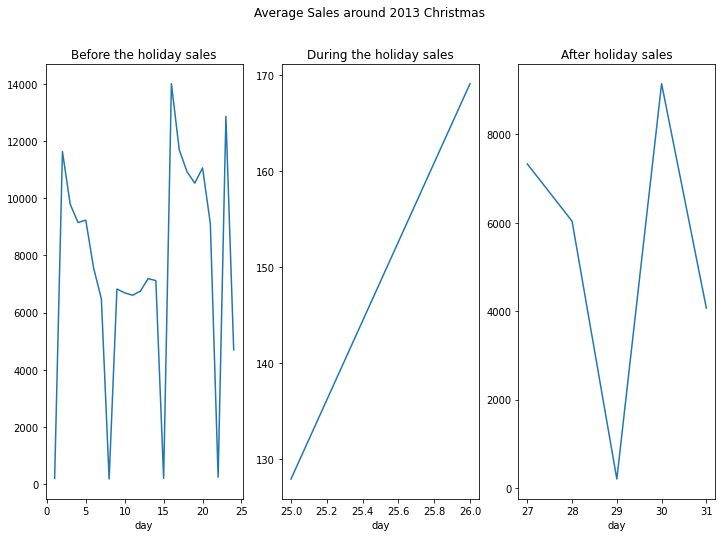

In [273]:
fig, axes = plt.subplots(1,3,figsize=(12,8))
fig.suptitle("Average Sales around 2013 Christmas")
avg_sales_before_2013.plot(ax=axes[0])
axes[0].set_title('Before the holiday sales')

avg_sales_during_2013.plot(ax=axes[1])
axes[1].set_title('During the holiday sales')

avg_sales_after_2013.plot(ax=axes[2])
axes[2].set_title('After holiday sales')
plt.show()

In [274]:
# For the year 2014
before = merged_train_df.query('day < 25 and month == 12 and year == 2014')
during = merged_train_df.query('(day == 25 or day == 26) and month == 12 and year == 2014')
after = merged_train_df.query('day > 26 and month == 12 and year == 2014')

In [275]:
avg_sales_before_2014 = before.groupby(before['day'])['Sales'].mean()
avg_sales_during_2014 = during.groupby(during['day'])['Sales'].mean()
avg_sales_after_2014 = after.groupby(after['day'])['Sales'].mean()

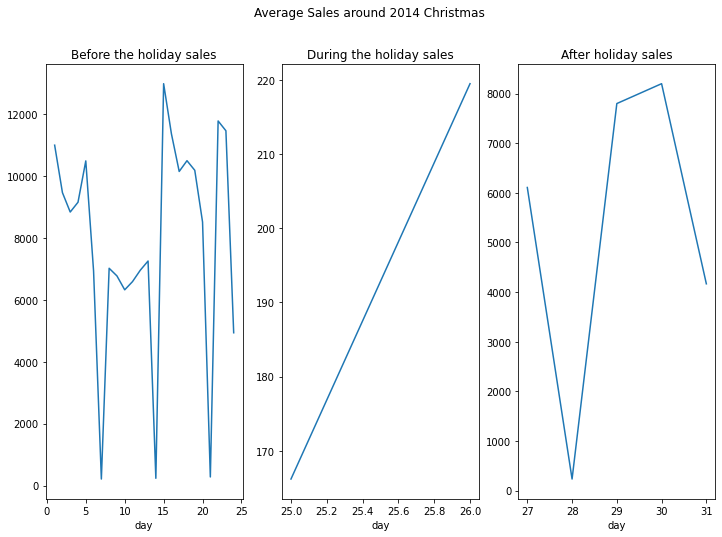

In [276]:
fig, axes = plt.subplots(1,3,figsize=(12,8))
fig.suptitle("Average Sales around 2014 Christmas")
avg_sales_before_2014.plot(ax=axes[0])
axes[0].set_title('Before the holiday sales')

avg_sales_during_2014.plot(ax=axes[1])
axes[1].set_title('During the holiday sales')

avg_sales_after_2014.plot(ax=axes[2])
axes[2].set_title('After holiday sales')
plt.show()

We can see that the shopping pattern around christmas is the same for 2013 and 2014

Easter Holiday Dates

In [278]:
easter_date = merged_train_df[merged_train_df['StateHoliday'] == 'b'].index.unique()

In [279]:
easter_date

DatetimeIndex(['2015-04-06', '2015-04-03', '2014-04-21', '2014-04-18',
               '2013-04-01', '2013-03-29'],
              dtype='datetime64[ns]', name='Date', freq=None)

For 2013 Easter is from March 29th to April 1st  
For 2014 Easter is from April 18th to April 21st  
For 2015 Easter is from April 3rd to April 06th

In [284]:
# Analysis for 2013
before = merged_train_df.query('day < 29 and month == 3 and year == 2013')
during = merged_train_df.query('(day > 29 and month == 3) or (day < 2 and month == 4) and year == 2013')
after = merged_train_df.query('day > 2 and month == 4 and year == 2013')

In [285]:
avg_sales_before_2013 = before.groupby(before['day'])['Sales'].mean()
avg_sales_during_2013 = during.groupby(during['day'])['Sales'].mean()
avg_sales_after_2013 = after.groupby(after['day'])['Sales'].mean()

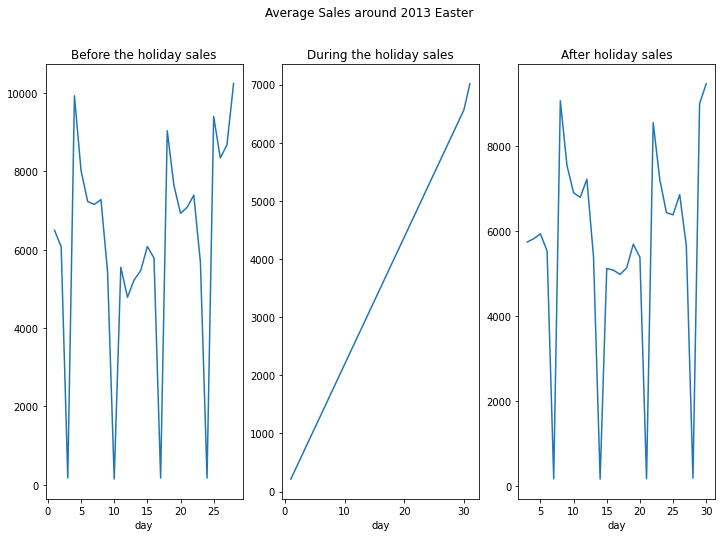

In [286]:
fig, axes = plt.subplots(1,3,figsize=(12,8))
fig.suptitle("Average Sales around 2013 Easter")
avg_sales_before_2013.plot(ax=axes[0])
axes[0].set_title('Before the holiday sales')

avg_sales_during_2013.plot(ax=axes[1])
axes[1].set_title('During the holiday sales')

avg_sales_after_2013.plot(ax=axes[2])
axes[2].set_title('After holiday sales')
plt.show()

In [288]:
# Analysis for 2014
before = merged_train_df.query('day < 18 and month == 4 and year == 2014')
during = merged_train_df.query('(day > 17 and day < 22) and month == 4 and year == 2014')
after = merged_train_df.query('day > 21 and month == 4 and year == 2014')

In [289]:
avg_sales_before_2014 = before.groupby(before['day'])['Sales'].mean()
avg_sales_during_2014 = during.groupby(during['day'])['Sales'].mean()
avg_sales_after_2014 = after.groupby(after['day'])['Sales'].mean()

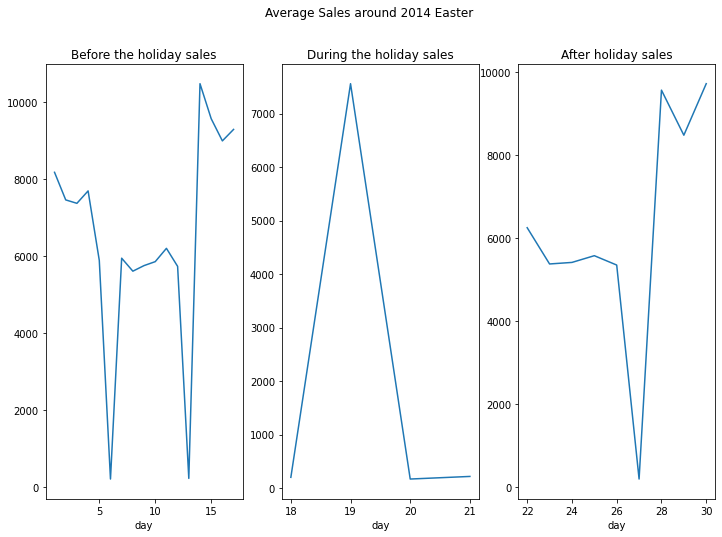

In [291]:
fig, axes = plt.subplots(1,3,figsize=(12,8))
fig.suptitle("Average Sales around 2014 Easter")
avg_sales_before_2014.plot(ax=axes[0])
axes[0].set_title('Before the holiday sales')

avg_sales_during_2014.plot(ax=axes[1])
axes[1].set_title('During the holiday sales')

avg_sales_after_2014.plot(ax=axes[2])
axes[2].set_title('After holiday sales')
plt.show()

In [292]:
# Analysis for 2015
before = merged_train_df.query('day < 3 and month == 4 and year == 2015')
during = merged_train_df.query('(day > 2 and day < 7) and month == 4 and year == 2015')
after = merged_train_df.query('day > 6 and month == 4 and year == 2015')

In [293]:
avg_sales_before_2015 = before.groupby(before['day'])['Sales'].mean()
avg_sales_during_2015 = during.groupby(during['day'])['Sales'].mean()
avg_sales_after_2015 = after.groupby(after['day'])['Sales'].mean()

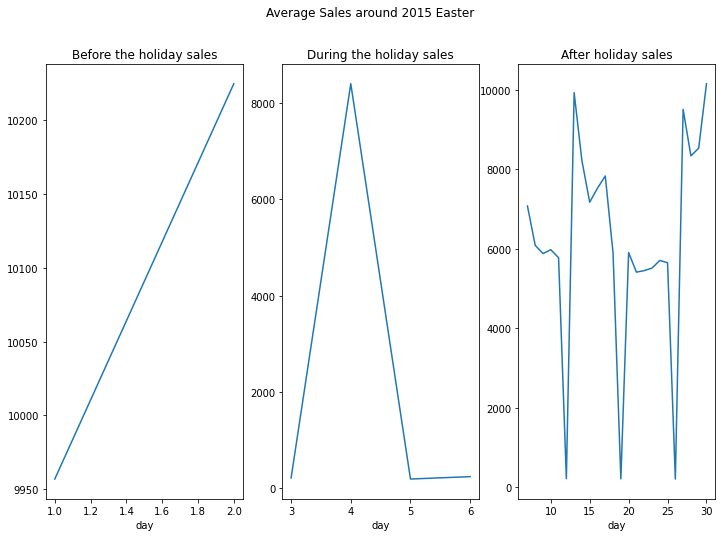

In [294]:
fig, axes = plt.subplots(1,3,figsize=(12,8))
fig.suptitle("Average Sales around 2015 Easter")
avg_sales_before_2015.plot(ax=axes[0])
axes[0].set_title('Before the holiday sales')

avg_sales_during_2015.plot(ax=axes[1])
axes[1].set_title('During the holiday sales')

avg_sales_after_2015.plot(ax=axes[2])
axes[2].set_title('After holiday sales')
plt.show()

#### How does promo affect sales? Are the promos attracting more customers? How does it affect already existing customers?

In [296]:
promo_sales = merged_train_df.query('Promo == 1')
no_promo_sales = merged_train_df.query('Promo == 0')

In [298]:
promo_sales_agg = promo_sales.groupby("month").agg({"Sales":  "mean"})
promo_sales_agg = promo_sales_agg.rename(columns={"Sales": "Avg Promotion Sales"})

no_promo_sales_agg = no_promo_sales.groupby("month").agg({"Sales":  "mean"})
no_promo_sales_agg = no_promo_sales_agg.rename(columns={"Sales": "Avg Non-Promotion Sales"})


promo_non_promo_sales_df = pd.merge(promo_sales_agg, no_promo_sales_agg, on="month")

sales_increase_df = promo_non_promo_sales_df["Avg Promotion Sales"] - promo_non_promo_sales_df["Avg Non-Promotion Sales"]

promo_non_promo_sales_df["increase percent"] = (sales_increase_df/promo_non_promo_sales_df["Avg Non-Promotion Sales"]) * 100
display(promo_non_promo_sales_df)
# plots.plot_bar(promo_non_promo_sales_df, promo_non_promo_sales_df.index,
#                "increase percent", "The overall sales increase percentage for each month due to promotion",
#                "Month", "Sales increase in percent")

,Avg Promotion Sales,Avg Non-Promotion Sales,increase percent
month,,,
1,7637.813837,4154.433175,83.847315
2,7746.883378,4477.680801,73.011068
3,8011.451617,4246.012246,88.681783
4,7948.050722,4266.077711,86.308156
5,7276.331266,4361.203367,66.842283
6,8177.309526,4362.027708,87.465786
7,8231.498481,4500.161489,82.915624
8,7860.176928,4407.173499,78.349614
9,7893.042646,4242.340072,86.053982


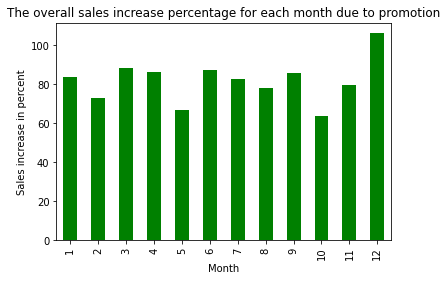

In [301]:
ax = promo_non_promo_sales_df["increase percent"].plot(kind="bar",colormap='green')
ax.set_title("The overall sales increase percentage for each month due to promotion")
ax.set_xlabel("Month")
ax.set_ylabel("Sales increase in percent")
plt.show()

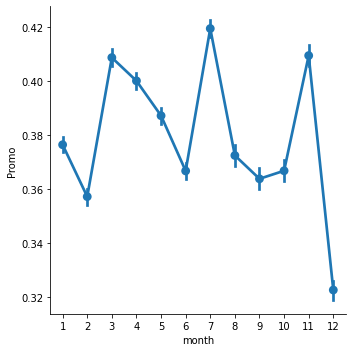

In [304]:
sns.factorplot(data=merged_train_df, x='month', y='Promo')

Effect of promotion on Sales

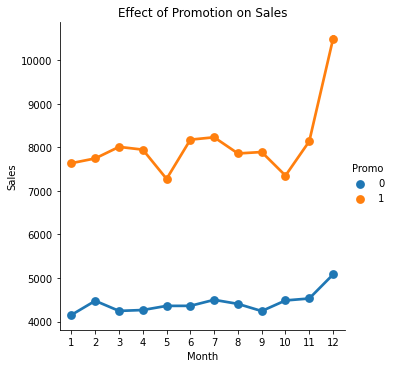

In [309]:
ax = sns.factorplot(data=merged_train_df, x='month', y='Sales', hue='Promo')
ax.set(xlabel='Month', ylabel='Sales', title='Effect of Promotion on Sales')
# ax.fig.suptitle("Effect of Promotion on Sales", fontsize=20)
# ax.set_xlabel("Month")
# ax.set_ylabel("Sales")
plt.show()


From the above plot it can be seen that there is a significant increase in average sales when there is promotion. The promotion had huge impact during the month of December.

### Effect of promotion on Customer 

In [316]:
promo_customer = merged_train_df.query('Promo == 1')
no_promo_customer = merged_train_df.query('Promo == 0')

In [323]:
promo_customers = merged_train_df[merged_train_df.Promo == 1]
non_promo_customers = merged_train_df[merged_train_df.Promo == 0]

promo_customers_agg = promo_customers.groupby("month").agg({"Customers":  "mean"})
promo_customers_agg = promo_customers_agg.rename(columns={"Customers": "Promotion-customers"})

non_promo_customers_agg = non_promo_customers.groupby("month").agg({"Customers":  "mean"})
non_promo_customers_agg = non_promo_customers_agg.rename(columns={"Customers": "Non-promotion-customers"})


promo_non_promo_customers = pd.merge(promo_customers_agg, non_promo_customers_agg, on="month")


cus_increase_diff = promo_non_promo_customers["Promotion-customers"] - promo_non_promo_customers["Non-promotion-customers"]
promo_non_promo_customers["increase percent"] = (cus_increase_diff/promo_non_promo_customers["Non-promotion-customers"]) * 100
display(promo_non_promo_customers)



,Promotion-customers,Non-promotion-customers,increase percent
month,,,
1,784.409430,491.309793,59.656787
2,802.366338,529.131124,51.638469
3,819.882134,497.797472,64.701948
4,813.912182,508.413453,60.088640
5,757.219283,503.952514,50.256078
6,824.967387,508.904288,62.106590
7,834.390619,528.246955,57.954648
8,831.339658,530.450796,56.723237
9,832.362271,521.288934,59.673881


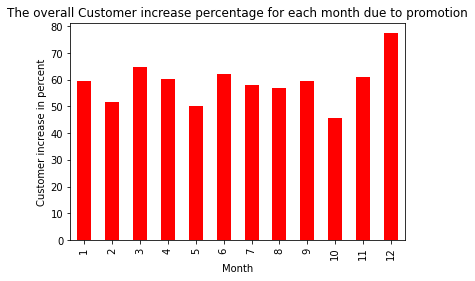

In [326]:
ax = promo_non_promo_customers["increase percent"].plot(kind="bar",color='red')
ax.set_title("The overall Customer increase percentage for each month due to promotion")
ax.set_xlabel("Month")
ax.set_ylabel("Customer increase in percent")
plt.show()

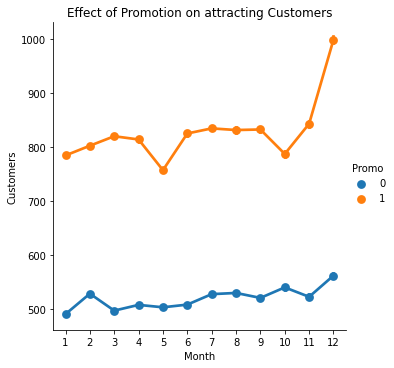

In [327]:
ax = sns.factorplot(data=merged_train_df, x='month', y='Customers', hue='Promo')
ax.set(xlabel='Month', ylabel='Customers', title='Effect of Promotion on attracting Customers')
plt.show()


As shown in the above figure, promotion directly impacts the number of Customers. 

#### Could the promos be deployed in more effective ways? Which stores should promos be deployed in?

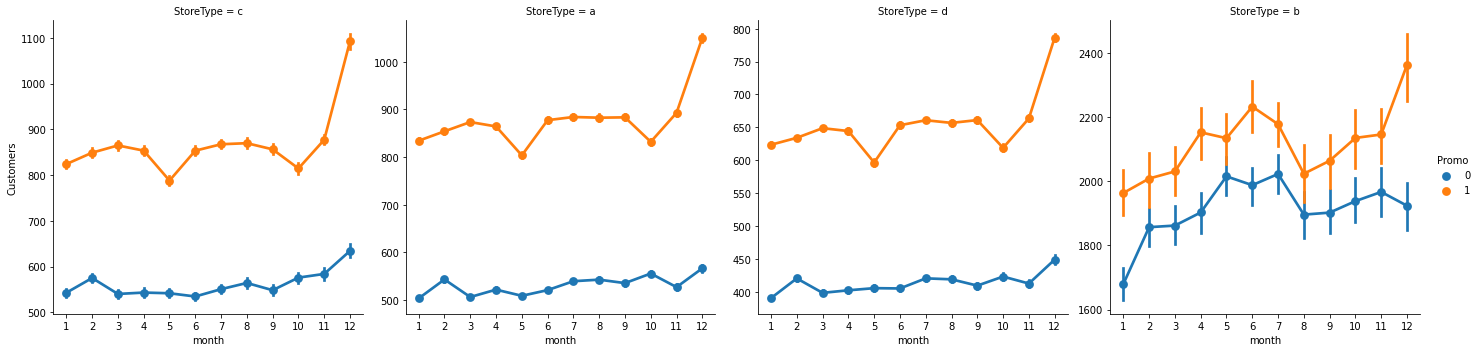

In [344]:
sns.factorplot(data = merged_train_df, x ="month", y = "Customers", 
               col = 'StoreType',
               hue = 'Promo',
               title="Promotion effect on Attracting Customers For Each Store", figsize=(12,8),sharey=False,sharex=False)

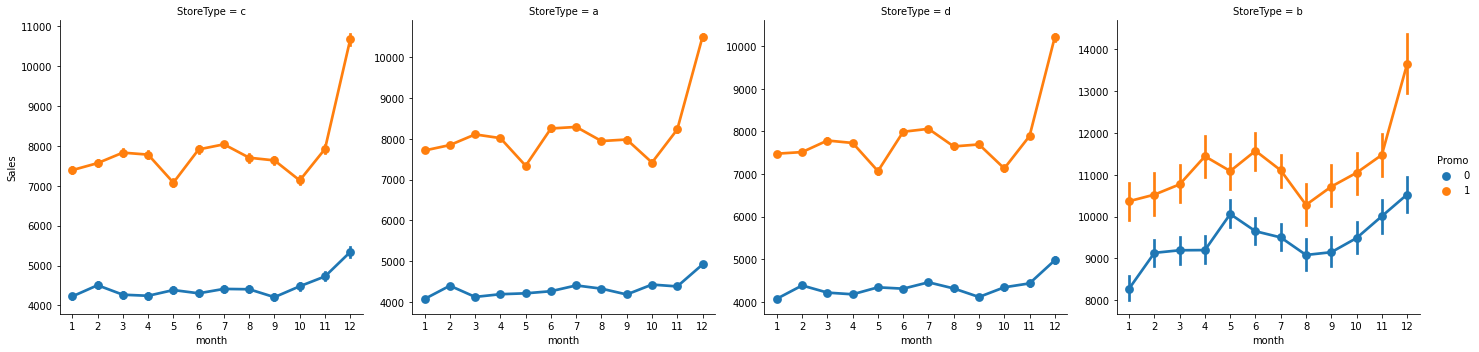

In [343]:
sns.factorplot(data = merged_train_df, x ="month", y = "Sales", 
               col = 'StoreType',
               hue = 'Promo',sharey=False,sharex=False)

Promotion seems to have a bigger impact in StoreType 'a'. We can see there is almost 100% increase in sales due to promotion.

#### Trends of customer behavior during store open and closing times

Commonly closing times are assumed to be Sundays. Opening times range from Monday to Saturday

In [367]:
non_holiday_sales = merged_train_df[merged_train_df['StateHoliday'] == '0']
holiday_sales = merged_train_df[merged_train_df['StateHoliday'] == '0']
sunday_stores = non_holiday_sales[(non_holiday_sales["DayOfWeek"] == 7) & (non_holiday_sales["Open"] == 1)]["Store"].unique()
weekday_sales = non_holiday_sales[non_holiday_sales['DayOfWeek'] != '7']

In [368]:
sunday_sales_df = merged_train_df[merged_train_df["Store"].isin(sunday_stores)]
sunday_open_customers = sunday_sales_df.groupby("DayOfWeek").agg({"Customers": "mean"})

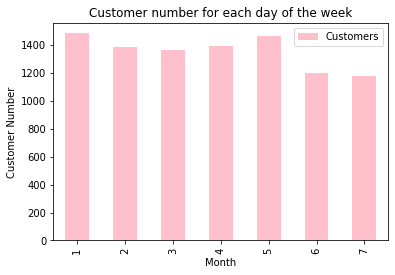

In [370]:
ax = sunday_open_customers.plot(kind="bar",color='pink')
ax.set_title("Customer number for each day of the week")
ax.set_xlabel("Month")
ax.set_ylabel("Customer Number")
plt.show()

#### Which stores are opened on all weekdays? How does that affect their sales on weekends? 

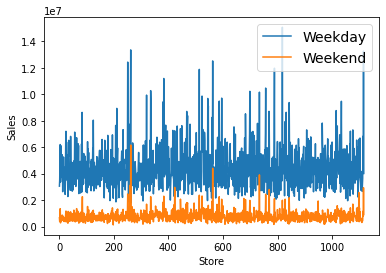

In [393]:
stores_open_on_weekdays = merged_train_df.query("Open==1")['Store'].unique()
sales_stores_open_on_weekdays = merged_train_df[(merged_train_df["Store"].isin(stores_open_on_weekdays) &merged_train_df['Open']==1 & ~merged_train_df['DayOfWeek'].isin([6,7]))].groupby('Store')['Sales'].sum()
sns.lineplot(data=sales_stores_open_on_weekdays)
sales_stores_open_on_weekdays = merged_train_df[(merged_train_df["Store"].isin(stores_open_on_weekdays) & merged_train_df['Open']==1 & merged_train_df['DayOfWeek'].isin([6,7]))].groupby('Store')['Sales'].sum()
sns.lineplot(data=sales_stores_open_on_weekdays)
plt.legend(['Weekday', 'Weekend'], fontsize=14, loc='upper right')
plt.show()

#### Check how the assortment type affects sales

In [396]:
a_assortment_df = merged_train_df[merged_train_df.Assortment == 'a']
b_assortment_df = merged_train_df[merged_train_df.Assortment == 'b']
c_assortment_df = merged_train_df[merged_train_df.Assortment == 'c']

a_sales_agg = a_assortment_df.groupby("month").agg({"Sales":  "mean"})
a_sales_agg = a_sales_agg.rename(columns={"Sales": "A-type assortment sales"})

b_sales_agg = b_assortment_df.groupby("month").agg({"Sales":  "mean"})
b_sales_agg = b_sales_agg.rename(columns={"Sales": "B-type assortment sales"})

c_sales_agg = c_assortment_df.groupby("month").agg({"Sales":  "mean"})
c_sales_agg = c_sales_agg.rename(columns={"Sales": "C-type assortment sales"})

assortment_sales = pd.merge(a_sales_agg, b_sales_agg, on="month")
assortment_sales = pd.merge(assortment_sales, c_sales_agg, on="month")


display(assortment_sales)


,A-type assortment sales,B-type assortment sales,C-type assortment sales
month,,,
1,5244.218557,7426.112306,5686.660861
2,5396.380089,8104.128307,5889.798663
3,5499.371503,8224.057348,6071.465153
4,5477.054244,8577.082716,5991.714815
5,5210.639323,9131.075269,5748.264667
6,5466.127693,8999.653086,6044.960386
7,5731.631242,8852.003722,6391.777452
8,5324.694316,7949.796964,6063.191033
9,5294.767818,8254.686275,5829.499342


Text(0, 0.5, 'Sales')

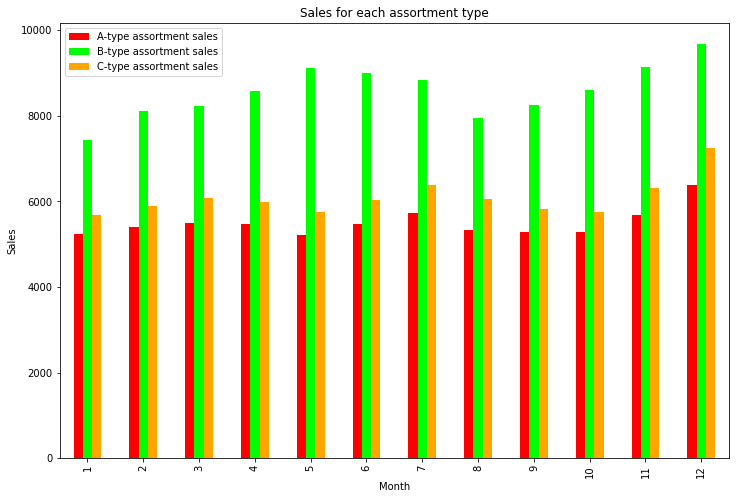

In [402]:

ax = assortment_sales.plot(kind="bar", figsize=(12,8), color=['red','lime','orange'])
ax.set_title("Sales for each assortment type")
ax.set_xlabel("Month")
ax.set_ylabel("Sales")

We can see from the above plot, the average sales is higher in the B-type assortment. Average sales is the lowest in A-type assortment.

#### How does the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centres, does the distance matter in that case?

,Sales,CompetitionDistance
Sales,1.000000,-0.018869
CompetitionDistance,-0.018869,1.000000


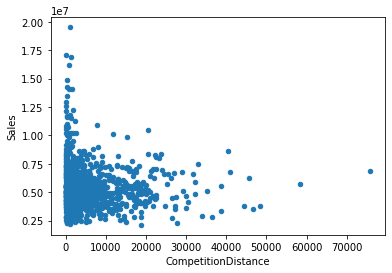

In [406]:
competition_df = merged_train_df[["Store", "Sales", "Customers", "StoreType", "CompetitionDistance"]]
competition_df_agg = competition_df.groupby("Store").agg({"Sales": "sum", "Customers" : "sum",
                                                      "CompetitionDistance": lambda x: max(x)})
competition_df_agg.plot(x='CompetitionDistance', y='Sales',kind='scatter')

competition_df_corr = competition_df[["Sales", "CompetitionDistance"]].corr()
display(competition_df_corr)

# plots.plot_heatmap(competition_df_corr, "Correlation between Competition Distance and Sales")

There is low correlation between CompetitionDistance and Sales. This means distance doesn't have much impact in determining Sales

#### How does the opening or reopening of new competitors affect stores? Check for stores with NA as competitor distance but later on has values for competitor distance

In [409]:
(merged_train_df['CompetitionOpenSinceMonth']==0).sum()

323348

In [412]:
store_df_1 = utils.load_data_dvc('v0-raw','data/store.csv','/home/teddy/dev/learning/10 academy/working/pharma_sales_prediction')
sales_train_df_1 = utils.load_data_dvc('v0-raw','data/train.csv','/home/teddy/dev/learning/10 academy/working/pharma_sales_prediction')
sales_test_df_1 = utils.load_data_dvc('v0-raw','data/test.csv','/home/teddy/dev/learning/10 academy/working/pharma_sales_prediction')

In [413]:
merged_train_df_1 = pd.merge(sales_train_df_1, store_df_1, on="Store")

Create a date-time column to compare before and after using year and month. The assumption taken is the day would be the first day of the month. 

In [414]:
has_open_competition_df = merged_train_df_1[merged_train_df_1['CompetitionOpenSinceMonth'].notnull()]

has_open_competition_df["CompetitionOpenSinceYear"] = has_open_competition_df["CompetitionOpenSinceYear"].astype("int").astype("str")
has_open_competition_df["CompetitionOpenSinceMonth"] = has_open_competition_df["CompetitionOpenSinceMonth"].astype("int").astype("str")

has_open_competition_df["CompetitionOpenSinceDate"] = has_open_competition_df["CompetitionOpenSinceYear"] + "-" + has_open_competition_df["CompetitionOpenSinceMonth"] + "-" + "01" 
has_open_competition_df["CompetitionOpenSinceDate"] =  pd.to_datetime(has_open_competition_df["CompetitionOpenSinceDate"])

competition_df = has_open_competition_df[["Date", "Sales", "Store", "CompetitionOpenSinceDate"]]


competition_df["BeforeCompetition"] = competition_df["Date"] < competition_df["CompetitionOpenSinceDate"]

competition_df_agg = competition_df.groupby("BeforeCompetition").agg({"Sales": "mean"})

In [415]:
print("Overall avg sales before and after competition")
display(competition_df_agg)

decrease = competition_df_agg["Sales"][True] - competition_df_agg["Sales"][False]
decrease_percent = decrease / competition_df_agg["Sales"][True]

print(f"Overall avg sales decreased after competition by {decrease_percent * 100:.3f}%")

Overall avg sales before competition and after competition


,Sales
BeforeCompetition,
False,5753.971338
True,5974.642737


Overall avg sales decreased after competition by 3.693%
